In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import corner

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}", "   ", type(device))

Using device: cuda     <class 'torch.device'>


In [3]:
from datasets.sinusoid import SinusoidDataset, double_batch
from models.misc import Patchify1d, UnPatchify1d, PositionEmbedder, TimestepEmbedder, MLP, DiTBlock

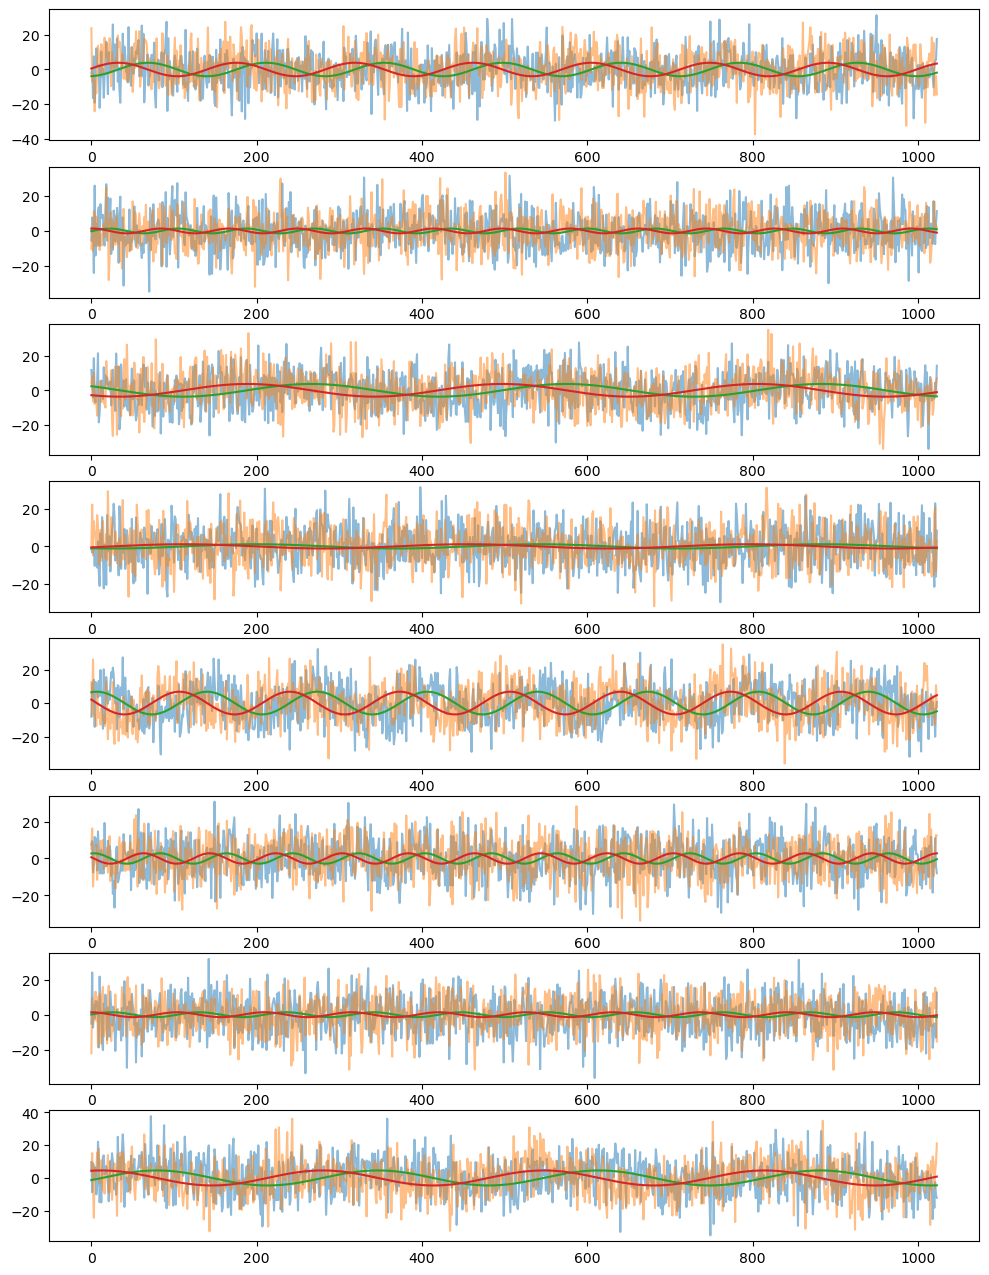

In [4]:
dataset = SinusoidDataset(dual_channel=True)

t, params, clean_signal, noisy_signal = next(iter(dataset.dataloader(batch_size=8)))
examples, channels = clean_signal.shape[0], clean_signal.shape[-1]
plt.figure(figsize=(12, 2 * len(t)))
for i in range(examples):
    plt.subplot(examples, 1, i + 1)
    for c in range(channels):
        plt.plot(noisy_signal[i, :, c], label="datastream", alpha=0.5)
    for c in range(channels):
        plt.plot(clean_signal[i, :, c], label="clean signal")

In [5]:
class CNF(nn.Module):
    def __init__(self, d_shape, hidden_dim=64, heads=8, depth=4, patch_size=16):
        super().__init__()
        self.coupling_sigma = 1e-5

        # conditioning embedding
        self.timestep_embed = TimestepEmbedder(hidden_dim)
        self.condition_embed = MLP(
            int(np.prod(d_shape)), 4 * hidden_dim, hidden_dim, hidden_layers=4
        )

        # time series embeddig
        self.position_embed = PositionEmbedder(hidden_dim, max_period=1000)
        self.patch_embed_d = Patchify1d(d_shape[-1], hidden_dim, patch_size)
        self.patch_embed_x = Patchify1d(d_shape[-1], hidden_dim, patch_size)

        # flow model
        self.dit_blocks = nn.ModuleList(
            DiTBlock(hidden_dim, heads) for _ in range(depth)
        )
        self.patch_unembed_x = UnPatchify1d(hidden_dim, d_shape[-1], patch_size)

    def forward(self, t, x, d):
        c = self.timestep_embed(t) + self.condition_embed(d.flatten(1))
        x = self.patch_embed_x(x) + self.patch_embed_d(d) 
        x += self.position_embed(x)

        for block in self.dit_blocks:
            x = block(x, c)
        x = self.patch_unembed_x(x)
        return x

    def loss(self, t, x0, x1, d):
        xt_mean = t[..., None] * x1 + (1 - t[..., None]) * x0
        xt = Normal(xt_mean, self.coupling_sigma).rsample()
        flow = self(t, xt, d)
        target_flow = x1 - x0
        return F.mse_loss(flow, target_flow)

    def push(self, x, datastream, ode_steps=32):
        with torch.no_grad():
            d = torch.stack([datastream] * x.shape[0])
            for t in tqdm(np.arange(0, 1, 1 / ode_steps)):
                t = t * torch.ones_like(x)[..., :1]
                v = self(t, x, d)
                x = x + v * 1 / ode_steps
            return x

# Train

In [6]:
dataset = double_batch(SinusoidDataset)(dual_channel=True)
model = CNF(d_shape=(1024, 2), hidden_dim=64, depth=4, patch_size=16)
print(model)

CNF(
  (timestep_embed): TimestepEmbedder(
    (pos_embedder): PositionEmbedder()
    (mlp): MLP(
      (0): Linear(in_features=256, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (condition_embed): MLP(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): SiLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): SiLU()
    (8): Linear(in_features=256, out_features=64, bias=True)
  )
  (position_embed): PositionEmbedder()
  (patch_embed_d): Patchify1d(
    (patch_embed): MLP(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): SiLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
    )
  )
  (patch_embed_x): Patchify1d(
    (patch_embed): MLP(
      (0): Linear(in_features=32, out_featur

In [7]:
def to_device(batch):
    return (el.to(device, non_blocking=True) for el in batch)


num_epochs = 100
dataloader = dataset.dataloader(batch_size=1024, num_workers=2)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

loss_history = []
model = model.to(device)
for epoch in (pbar := tqdm(range(num_epochs))):
    loss_history.append([])
    for i, batch in enumerate(tqdm(dataloader, leave=False)):
        t_1, par_1, clean_1, noisy_1, t_2, par_2, clean_2, noisy_2 = to_device(batch)

        # pushing (clean1 -> clean2 | noisy2) and (clean2 -> clean1 | noisy1)
        loss = model.loss(t=t_1, x0=clean_1, x1=clean_2, d=noisy_2)
        loss += model.loss(t=t_2, x0=clean_2, x1=clean_1, d=noisy_1)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history[-1].append(loss.item())
        pbar.set_postfix(loss_flow=loss.item())
loss_flow_history = np.array(loss_history)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [01:09<?, ?it/s, loss_flow=11.4]

/tmp/ipykernel_653979/3809302666.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, losses.mean(-1).max())


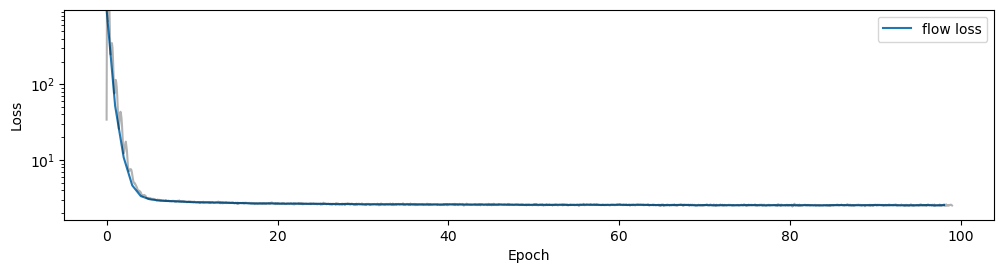

In [29]:
plt.figure(figsize=(12, 6))
for i, (label, losses) in enumerate([("flow", np.array(loss_flow_history[:-1]))]):
    plt.subplot(2, 1, i + 1)
    plt.semilogy(losses.mean(-1), label=f"{label} loss")
    smooth_times = np.arange(np.prod(losses.shape)) / losses.shape[-1]
    plt.semilogy(smooth_times, losses.flatten(), "k", alpha=0.3)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.ylim(0, losses.mean(-1).max())

In [30]:
import emcee
def Hessian(theta_max, t, d):
    [A, w, phi] = theta_max
    arg = w * t + phi
    cos = np.cos(arg)
    sin = np.sin(arg)
    Del = d - A * sin
    H11 = 2 * np.sum(sin**2)
    H22 = 2 * A * np.sum(t**2 * (Del * sin + A * cos**2))
    H33 = 2 * A * np.sum(Del * sin + A * cos**2)
    H12 = 2 * np.sum(t * (A * sin * cos - Del * cos))
    H13 = 2 * np.sum(A * sin * cos - Del * cos)
    H23 = 2 * A * np.sum(t * (Del * sin + A * cos**2))
    H = np.array([[H11, H12, H13], [H12, H22, H23], [H13, H23, H33]])
    return H


##########################################################   # Per la postirior di MCMC:
def log_prior(theta):  #Volendo si potrebbe mettere la prior ma l'MCMC non esce mai dal bordo della prior
  return 0.0

def theoretical_waveform(theta, t):
  [A,omega,phi] = theta
  x_t = (A * np.sin(omega* t + phi))
  return x_t

def emcee_sampler(log_post, x0, nburn=300, steps=10000, **kwargs):  # Funzione MCMC 1
    mnwalkers, mndim = x0.shape
    sampler = emcee.EnsembleSampler(mnwalkers,
                                    mndim,
                                    log_post)
    sampler.run_mcmc(x0, nburn, progress=False,tune=True)
    state = sampler.get_chain()[-1, :, :]
    sampler.reset()
    #print('Finished initial run, burn-in dropped and starting real run')
    sampler.run_mcmc(state, steps, progress=False,tune=True)
    return sampler.get_log_prob(), sampler.get_chain()

def big_sampler(t, y,sigma_y,theoretical_waveform, theta0, log_prior=lambda _:0.0, nburn=300, steps=3000):   # Funzione MCMC 2 (servono entrambe, la 2 chiama la 1)
    def log_posterior(theta):
        if log_prior(theta)==0.0:
            res=np.abs(y-theoretical_waveform(theta, t))/sigma_y
            return -np.sum(res**2)/2   # *2 -0.5*2*np.pi*np.sum(sigma_y) + log_prior(theta)
        else:
            return -np.inf
    ndim=len(theta0)
    nwalkers=8*ndim
    p0=np.zeros((nwalkers,ndim))
    for i in range(nwalkers):
        p0[i]=theta0*np.random.normal(loc=1.0, scale=0.001, size=ndim)
    return emcee_sampler(log_posterior, p0, nburn=nburn, steps=steps)

# results

In [34]:
model.eval()
plt.figure(figsize=(12, 2 * 5))
for k, batch in enumerate(DataLoader(dataset, batch_size=1024)):
    if k >= 5:
        break
    _, x0, params, datastream, clean_signal = (el.to(device) for el in batch)
    datastream, clean_signal, params = datastream[0], clean_signal[0], params[0]
    #params[..., :2] = torch.exp(params[..., :2])  # undo log
    params = params.cpu().numpy()
    params_min = params_max = np.array(params)

    # sample using CNF
    x1_cnf = model.push(x0, datastream, ode_steps=128)
    #x1_cnf[..., :2] = torch.exp(x1_cnf[..., :2])  # undo log

    # # sample using MCMC
    # x1_mcmc = big_sampler(
    #     dataset.times,
    #     datastream.cpu().numpy(),
    #     np.full(len(dataset.times), dataset.signal_noise_std),
    #     theoretical_waveform,
    #     params_min,
    #     log_prior=log_prior,
    #     nburn=50,
    #     steps=len(x1_cnf),
    # )
    # x1_mcmc = x1_mcmc[1].reshape(-1, 3)

    # sample using Fisher
    H = Hessian(params_max, dataset.times, datastream.cpu().numpy())  # Parte di Ficher
    cov = np.linalg.inv(H / (2 * dataset.signal_noise_std**2))
    x1_fisher = np.random.multivariate_normal(params_min, cov, len(x1_cnf) * (3 * 8))

    corner_kwargs = dict(labels=["A", "omega", "phi"], show_titles=True, truths=params)
    fig = corner.corner(x1_cnf.cpu().numpy(), color="blue", **corner_kwargs)
    # fig = corner.corner(x1_mcmc, color="red", **corner_kwargs, fig=fig)
    fig = corner.corner(x1_fisher, color="green", **corner_kwargs, fig=fig)

  0%|          | 0/128 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x9 and 1025x2048)

<Figure size 1200x1000 with 0 Axes>

(array([ 14.,  55.,  85., 127., 143., 163., 159., 148.,  95.,  35.]),
 array([0.34950674, 0.64493608, 0.94036543, 1.23579478, 1.53122413,
        1.82665348, 2.12208295, 2.41751218, 2.71294165, 3.00837088,
        3.30380034]),
 <BarContainer object of 10 artists>)

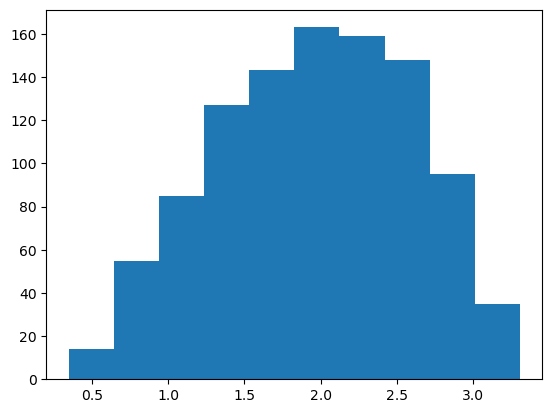

In [11]:
plt.hist(x1_cnf[:, 0].cpu().numpy())